<a href="https://colab.research.google.com/github/cipheraxat/Deep-Learning-Portfolio/blob/master/Pytorch/Fashion%20MNIST/fashionMNISTtraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
#basic libraries

import torch
import torchvision


In [41]:
#data loading and transforming

from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms

In [42]:
from collections import OrderedDict

#the output of torchvision datasets are PILImage images of range[0,1],
#we transform them to tensors for input into a CNN

##define a transform to read the data in as a tensor
data_transform = transforms.ToTensor()

#choose the training and test datasets
train_data = FashionMNIST(root='./data', train=True, download=True, transform=data_transform)
test_data = FashionMNIST(root='./data', train=False, download=True, transform=data_transform)

#printing out the details about the training and test data
print('Train data, number of images', len(train_data))
print('Test data, number of images', len(test_data))

Train data, number of images 60000
Test data, number of images 10000


In [43]:
#preparing data loaders, set the batch size
batch_size = 10

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)


#specifying the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Visualizing the training data

### we use dataiter.next() .It loads random batch of image/label data. its plots the batch of images and lables in 2 x batch_size/2 grid.

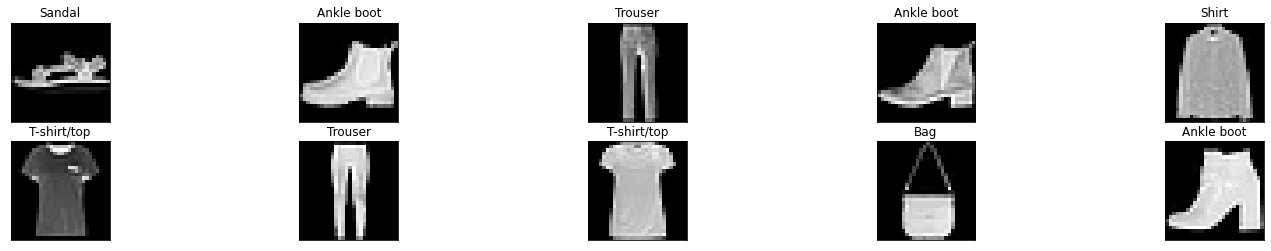

In [44]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

#obtains one batch of training images
dataiter = iter(train_loader)
images, labels =  dataiter.next()
images =  images.numpy()

#plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
   ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
   ax.imshow(np.squeeze(images[idx]), cmap='gray')
   ax.set_title(classes[labels[idx]]) 

## Defining the network architecture

## The simple series of layers consists of:

* Convolutional layers
* Maxpooling layers
* Fully-connected (linear) layers





### We will be using 
* Use at least two convolutional layers
* Your output must be a linear layer with 10 outputs (for the 10 classes of clothing)
* Use a dropout layer to avoid overfitting

In [45]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self, drop_p):
        super(Net, self).__init__()
        
        # 1 input image channel (grayscale), 10 output channels/feature maps
        # 3x3 square convolution kernel
        self.conv1 = nn.Conv2d(1, 10, 3, padding=1) #28x28x10
        
        ## TODO: Define the rest of the layers:
        # include another conv layer, maxpooling layers, and linear layers
        # also consider adding a dropout layer to avoid overfitting

        self.pool1 = nn.MaxPool2d(2, 2)  #14x14x10
        
        self.drop1 = nn.Dropout(drop_p)
       
        self.conv2 = nn.Conv2d(10, 20, 3, padding=1) #14x14x20
        self.pool2 = nn.MaxPool2d(2, 2)  #7x7x20
        self.drop2 = nn.Dropout(drop_p)

        self.linout = nn.Linear(7*7*20,10)
        
    ## TODO: define the feedforward behavior
    def forward(self, x):
        # one activated conv layer
        layer1 = self.drop1(self.pool1(F.relu(self.conv1(x))))
        layer2 = self.drop2(self.pool2(F.relu(self.conv2(layer1))))
        
        flat = layer2.view(layer2.size(0), -1)
        out = self.linout(flat)
        
        # final output
        return out

# instantiate and print your Net
net = Net(0.5)
print(net)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.5, inplace=False)
  (linout): Linear(in_features=980, out_features=10, bias=True)
)


## Specify the loss function and optimizer


### For a classification problem like this, one typically uses cross entropy loss by using criterion = nn.CrossEntropyLoss().
Pytorch also includes some standard stochastic optimizers like stochastic gradient descent and adam.

In [46]:
import torch.optim as optim

## specify loss function (try categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

## specify optimizer
optimizer = optim.Adam(net.parameters(), lr = 0.01)

### A note on accuracy
Its's interesting to look at the accuracy of your network Before and After training , in this way you will learn that your network has learned something.

In [47]:
# calculating accuracy before training

from torch.autograd import Variable

correct = 0
total = 0

#iterating through the test dataset
for images, labels in test_loader:

    #warp input images in a Variable wrapper 
    images = Variable(images)

    #forward pass to get outputs
    #the outputs are a series of class scores
    outputs = net.forward(images)

    #get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)

    #count up total number of correct labels
    #for which the predicted and true labels are equal
    total += labels.size(0)
    correct += (predicted == labels).sum()

#calculate the accuracy
accuracy = 100 * correct.item()/total

#print the accuracy
print('Accuracy before training:', accuracy)

Accuracy before training: 9.58


## Train the netwwork

The steps that this training function performs as it iterates over the training dataset:

* Wraps all tensors in Variables
* Zero's the gradients to prepare for a forward pass
* Passes the input through the network (forward pass)
* Computes the loss (how far is the predicted classes are from the correct labels)
* Propagates gradients back into the network’s parameters (backward pass)
* Updates the weights (parameter update)
* Prints out the calculated loss

In [48]:
from torch.autograd import Variable

def train(n_epochs):

  for epoch in range(n_epochs): #loop over the dataset multiple times
    
      running_loss = 0.0
      for batch_i, data in enumerate(train_loader):
        #get the input images and their corresponding labels

        inputs, labels = data

        #wrap them in a torch Variable
        #inputs, labels = Variable(inputs), Variable(labels)

        #zero the parameter (weight gradients)
        optimizer.zero_grad()

        #forward pass to get outputs
        outputs = net(inputs)

        #calculate the loss
        loss = criterion(outputs, labels)

        #backward pass to calculate the parameter gradients
        loss.backward()

        #update the parameters
        optimizer.step()

        #print loss statistics to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
        if batch_i % 1000 == 999:  #prints every 1000 mini-batches
            print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
            running_loss = 0.0

print('Finished Training')            


Finished Training


In [52]:
#define the number of epochs to train for
n_epochs = 5 #start small to see if your model works, intially

#call train
train(n_epochs)

Epoch: 1, Batch: 1000, Avg. Loss: 0.4220197434052825
Epoch: 1, Batch: 2000, Avg. Loss: 0.3954894227460027
Epoch: 1, Batch: 3000, Avg. Loss: 0.41545305328498944
Epoch: 1, Batch: 4000, Avg. Loss: 0.41843103801924736
Epoch: 1, Batch: 5000, Avg. Loss: 0.42475058397091925
Epoch: 1, Batch: 6000, Avg. Loss: 0.4253560676976922
Epoch: 2, Batch: 1000, Avg. Loss: 0.40569228193257006
Epoch: 2, Batch: 2000, Avg. Loss: 0.41880308764986696
Epoch: 2, Batch: 3000, Avg. Loss: 0.4215263575972058
Epoch: 2, Batch: 4000, Avg. Loss: 0.4079949621334672
Epoch: 2, Batch: 5000, Avg. Loss: 0.40292696822807195
Epoch: 2, Batch: 6000, Avg. Loss: 0.41415991001483055
Epoch: 3, Batch: 1000, Avg. Loss: 0.39388138735014944
Epoch: 3, Batch: 2000, Avg. Loss: 0.413601600591559
Epoch: 3, Batch: 3000, Avg. Loss: 0.43183505701087416
Epoch: 3, Batch: 4000, Avg. Loss: 0.4079549089577049
Epoch: 3, Batch: 5000, Avg. Loss: 0.40717579833604395
Epoch: 3, Batch: 6000, Avg. Loss: 0.41502362781297414
Epoch: 4, Batch: 1000, Avg. Loss: 0.

## Test the Trained Network

For FashionMNIST, which contains many pre-processed training images, a good model should reach greater than 85% accuracy on this test dataset. If you are not reaching this value, try training for a larger number of epochs, tweaking your hyperparameters, or adding/subtracting layers from your CNN.


In [53]:
#initialize tensor and lists to monitor test loss and accuracy

test_loss = torch.zeros(1)
class_correct = np.zeros(10)
class_total = np.zeros(10)

# set the moduke in evaluation mode
net.eval()

for batch_i, data in enumerate(test_loader):

     #get the images and their corresponding labels
     inputs, labels = data

     with torch.no_grad():
       #wrapping them in a torch variable
       #volatile means we do not have to track how the inputs change

       inputs, labels =  Variable(inputs), Variable(labels)

       #forward pass to get outputs
       outputs = net(inputs)

       #calculate the loss
       loss = criterion(outputs, labels)

       #update the average test loss
       test_loss = test_loss + ((torch.ones(1) / (batch_i +1))
       * (loss.data - test_loss))

       #get the unpredicted class from the maximum value in the output-list of class scores
       _, predicted =  torch.max(outputs.data, 1)

       #compare predictions to true label
       correct = np.squeeze(predicted.eq(labels.data.view_as(predicted))).float()

       #calculate test accuracy for *each* object class
       for i in range(batch_size):
          label = labels.data[i].item()
          class_correct[label] += correct[i]
          class_total[label] += 1

print('Test Loss: {:.6f}\n'.format(test_loss.numpy()[0]))
print(correct.dtype)
print(correct.size())

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no Training examples' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
     100. * np.sum(class_correct) / np.sum(class_total),
     np.sum(class_correct), np.sum(class_total)))            


Test Loss: 0.429956

torch.float32
torch.Size([10])
Test Accuracy of T-shirt/top: 80% (801/1000)
Test Accuracy of Trouser: 95% (957/1000)
Test Accuracy of Pullover: 65% (650/1000)
Test Accuracy of Dress: 87% (872/1000)
Test Accuracy of  Coat: 83% (833/1000)
Test Accuracy of Sandal: 95% (955/1000)
Test Accuracy of Shirt: 54% (544/1000)
Test Accuracy of Sneaker: 95% (951/1000)
Test Accuracy of   Bag: 96% (963/1000)
Test Accuracy of Ankle boot: 95% (952/1000)

Test Accuracy (Overall): 84% (8478/10000)


## Visualize sample test results

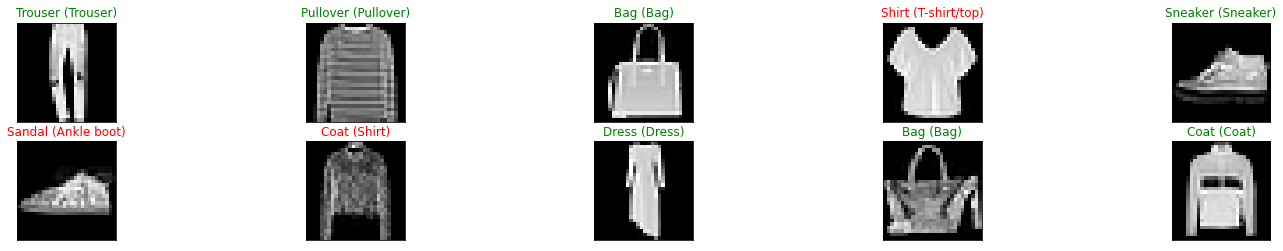

In [54]:
#obtaining one batch of test image
dataiter = iter(test_loader)
images, labels = dataiter.next()

#get predictions
with torch.no_grad():
   preds = np.squeeze(net(Variable(images)).data.max(1, keepdim=True)[1].numpy())
images = images.numpy()

#plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
   ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
   ax.imshow(np.squeeze(images[idx]), cmap='gray')
   ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))

In [ ]:
model_dir = 'saved_models/'
model_name = 'model_1.pt'
# after training, save your model parameters in the dir 'saved_models'
# when you're ready, un-comment the line below
torch.save(net.state_dict(), model_dir+model_name)

## Load a Trained, Saved Mode
To instantiate a trained model, you'll first instantiate a new Net() and then initialize it with a saved dictionary of parameters (from the save step above).

In [ ]:
# instantiate your Net
# this refers to your Net class defined above
net = Net()

# load the net parameters by name
# uncomment and write the name of a saved model
#net.load_state_dict(torch.load('saved_models/model_1.pt'))

print(net)

# Once you've loaded a specific model in, you can then 
# us it or further analyze it! 
# This will be especialy useful for feature visualization